Data Collection with CCXT

In [104]:
import ccxt
import pandas as pd

import warnings
warnings.simplefilter("ignore", category=FutureWarning)

# Initialize the exchange
exchange = ccxt.binance()

symbol = 'BTC/USDT'
timeframe = '1d'
since = exchange.parse8601('2021-01-01T00:00:00Z')
now = exchange.milliseconds()

all_candles = []

while since < now:
    candles = exchange.fetch_ohlcv(symbol, timeframe, since)
    if len(candles) == 0:
        break
    since = candles[-1][0] + 1  # start the next fetch from the end of the last one
    all_candles += candles

# Convert to DataFrame
df = pd.DataFrame(all_candles, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
df['date'] = pd.to_datetime(df['timestamp'], unit='ms')

# Create a copy with the closing price for forecasting
data = df[['date', 'close']].copy()
data.rename(columns={'date': 'ds', 'close': 'y'}, inplace=True)

print(data.head())

          ds         y
0 2021-01-01  29331.69
1 2021-01-02  32178.33
2 2021-01-03  33000.05
3 2021-01-04  31988.71
4 2021-01-05  33949.53


Plot the historical Bitcoin prices

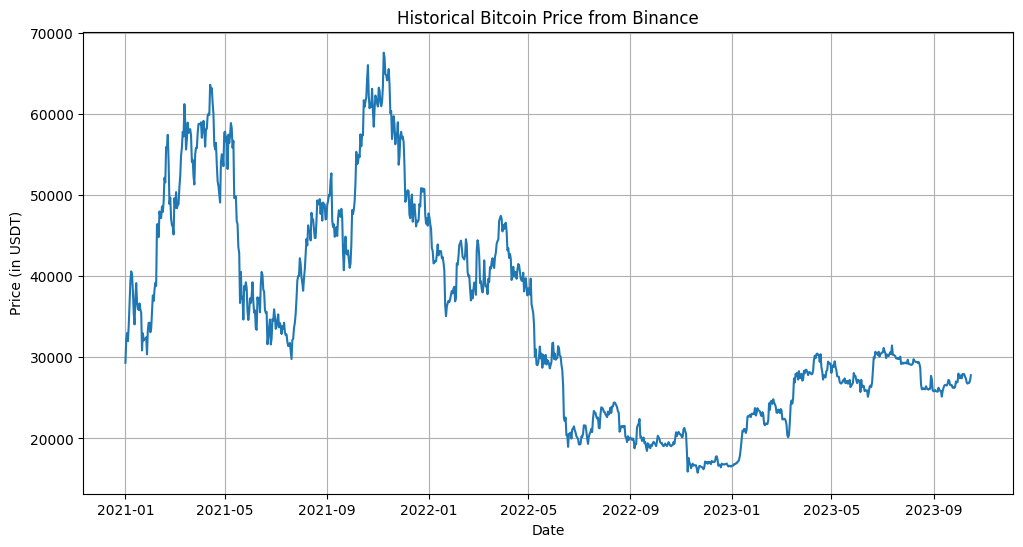

In [105]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(data['ds'], data['y'])
plt.title('Historical Bitcoin Price from Binance')
plt.xlabel('Date')
plt.ylabel('Price (in USDT)')
plt.grid(True)
plt.show()

Add additional regressors/features & Clean Data

In [106]:
import talib

data['rsi'] = talib.RSI(data['y'].values, timeperiod=16)
data.dropna(subset=['rsi'], inplace=True)

Fit and Train the Prophet model with features/regressors

In [107]:
from prophet import Prophet

# Initialize the Prophet model
model = Prophet()

# Add RSI as a regressor
model.add_regressor('rsi')

# Train the model with the data
model.fit(data)

08:44:50 - cmdstanpy - INFO - Chain [1] start processing
08:44:50 - cmdstanpy - INFO - Chain [1] done processing


Create future date data for which we want to predict the Bitcoin prices and then generate forecasts. Also demonstrate Forecasting with the Regressor/Feature

In [108]:
# Create future dates for prediction (e.g., for the next 365 days)
future = model.make_future_dataframe(periods=365)

# Since we need future values of RSI for prediction (which we don't have), 
# for demonstration purposes, let's just append the last RSI value for future dates
last_rsi_value = data['rsi'].iloc[-1]
future['rsi'] = last_rsi_value

# Generate forecasts
forecast = model.predict(future)

Visualize the predicted prices

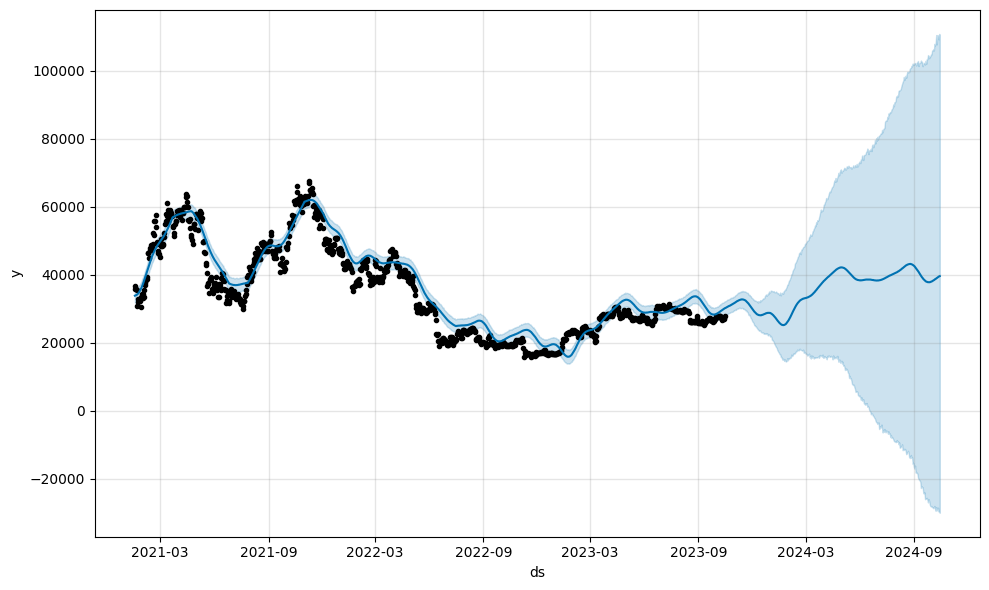

In [109]:
fig1 = model.plot(forecast)

 Break down the forecast into its various components

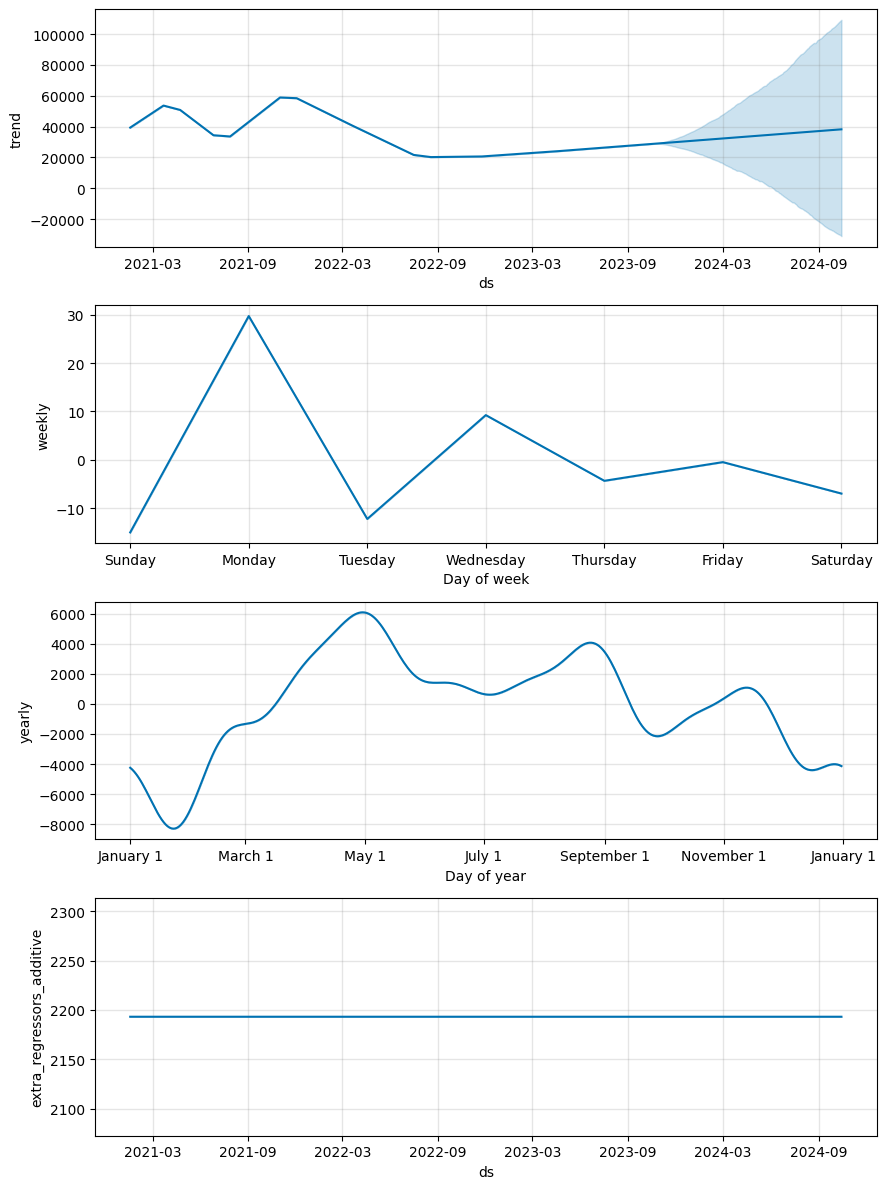

In [110]:
fig2 = model.plot_components(forecast)

**Predict the price of Bitcoin for tomorrow**

Generate a future dataframe for just one day

In [111]:
# Create a future date for prediction (just for tomorrow)

future_one_day = model.make_future_dataframe(periods=1)

Make the forecast:

In [112]:
# Assign the most recent RSI value for the future date
last_rsi_value = data['rsi'].iloc[-1]
future_one_day['rsi'] = last_rsi_value

forecast_one_day = model.predict(future_one_day)

Extract the forecast for tomorrow:

In [113]:
tomorrow_forecast = forecast_one_day[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(1)
print(tomorrow_forecast)

             ds          yhat    yhat_lower    yhat_upper
1003 2023-10-17  30199.648478  28190.577601  32199.534067


Setup & Perform Cross-Validation

In [114]:
from prophet.diagnostics import cross_validation

# Here's an example setup:
# Initial training period = 730 days (2 years)
# Horizon = 90 days
# Period = 30 days (i.e., make a forecast every 30 days)

df_cv = cross_validation(model, initial='730 days', period='30 days', horizon='90 days')


08:44:52 - cmdstanpy - INFO - Chain [1] start processing
08:44:52 - cmdstanpy - INFO - Chain [1] done processing
08:44:52 - cmdstanpy - INFO - Chain [1] start processing
08:44:52 - cmdstanpy - INFO - Chain [1] done processing
08:44:52 - cmdstanpy - INFO - Chain [1] start processing
08:44:52 - cmdstanpy - INFO - Chain [1] done processing
08:44:53 - cmdstanpy - INFO - Chain [1] start processing
08:44:53 - cmdstanpy - INFO - Chain [1] done processing
08:44:53 - cmdstanpy - INFO - Chain [1] start processing
08:44:53 - cmdstanpy - INFO - Chain [1] done processing
08:44:53 - cmdstanpy - INFO - Chain [1] start processing
08:44:54 - cmdstanpy - INFO - Chain [1] done processing
08:44:54 - cmdstanpy - INFO - Chain [1] start processing
08:44:54 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 7/7 [00:02<00:00,  2.61it/s]


Compute Performance Metrics

In [115]:
from prophet.diagnostics import performance_metrics

df_p = performance_metrics(df_cv)
print(df_p.head())

  horizon           mse         rmse          mae      mape     mdape  \
0  9 days  7.978688e+06  2824.657143  2298.522504  0.086311  0.069803   
1 10 days  8.419041e+06  2901.558303  2340.876903  0.087992  0.074863   
2 11 days  9.442034e+06  3072.789227  2401.862344  0.090679  0.074863   
3 12 days  1.070861e+07  3272.401450  2494.868392  0.094643  0.069803   
4 13 days  1.204686e+07  3470.858985  2621.887685  0.099837  0.067428   

      smape  coverage  
0  0.091491  0.476190  
1  0.093644  0.476190  
2  0.097646  0.476190  
3  0.103063  0.492063  
4  0.109639  0.507937  


Visualizing Performance

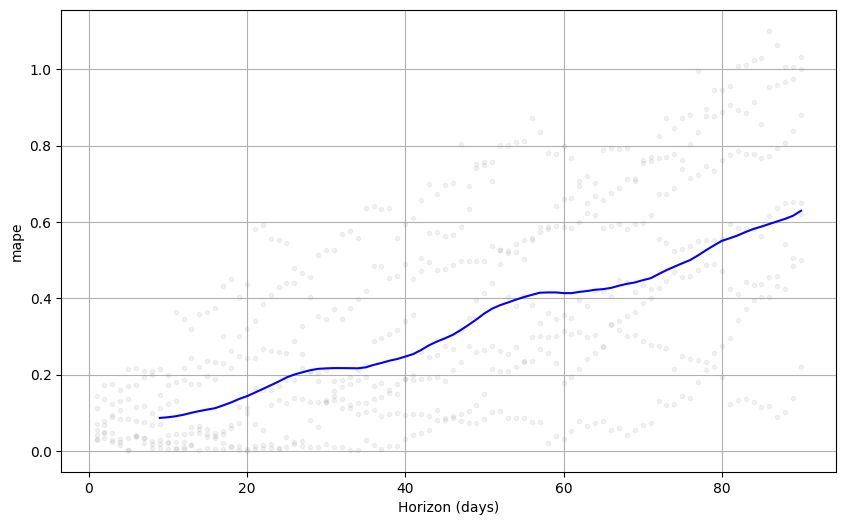

In [116]:
from prophet.plot import plot_cross_validation_metric

fig = plot_cross_validation_metric(df_cv, metric='mape')

Compute the percentage accuracy from MAPE

In [117]:
# Assuming df_p is the result from the performance_metrics function
mape = df_p['mape'].mean()
accuracy = 100 - (mape * 100)
print(f"Forecast Accuracy: {accuracy:.2f}%")

Forecast Accuracy: 66.20%
